# Phase 1: Literature and Dataset Survey

## Understand the Core Concepts:
- `Image classification` involves assigning a single label or class to an entire image based on its dominant content. The model answers the question, "What is in this picture?"
- `Object detection` goes a step further than classification. It not only identifies what objects are in an image but also where they are located. This is typically done by drawing bounding boxes around each detected object and assigning a class label to each box. The model answers, "What objects are in this picture, and where are they?"
- `Instance segmentation` is the most granular of the three. It combines object detection with semantic segmentation. For each object detected, it generates a pixel-level mask, precisely outlining the shape of each individual instance of an object. The model answers, "What objects are in this picture, where exactly are they, and what are their precise shapes?"

## Literature Search

For insights into common challenges and state-of-the-art models in surgical instrument detection, we refer to the provided paper: \
Paper Title: "Identifying Surgical Instruments in Pedagogical Cataract Surgery Videos through an Optimized Aggregation Network" \
Authors: Sanya Sinha, Michal Balazia, Francois Bremond \
Source: IPAS 2025 Sixth IEEE International Conference on Image Processing Applications and Systems

The authors propose a novel, lightweight object detection model inspired by the YOLOv9 architecture. Their key innovation is optimizing the Generally-Optimized Efficient Layer Aggregation Network (Go-ELAN) YOLOv9 architecture. This model incorporates two main mechanisms:
- Programmable Gradient Information (PGI): This mechanism introduces an auxiliary reversible branch that facilitates reliable gradient calculation and avoids potential semantic loss, addressing the information bottleneck problem.

- Optimized GELAN (Go-ELAN): This optimization involves increasing the size of downsampling filters from 128 to 512 to accommodate greater spatial context and introducing a label smoothening block with a coefficient of 0.1 into the loss computation framework.

The paper also discusses several challenges. The paper explicitly highlights the challenge of "lack of annotated data." The authors address this by creating their own custom dataset from open-access videos. The authors acknowledge that open-access videos are often of poor quality, as they are filmed on head-mounted cameras. They mitigate this by performing data augmentation techniques like contrast-limited adaptive histogram equalization (CLAHE). The "information bottleneck problem" during data traversal across network layers is identified as a constant risk. The PGI mechanism and Go-ELAN architecture are designed to overcome these challenges by retaining information and improving gradient flow.



## Dataset Search and Analysis
My primary task is to find a suitable public dataset for cataract surgery instrument detection. Based on the literature search, the paper itself introduces an ideal candidate. I chose to use `cataract-7smf8`, which is available on Roboflow Universe. It was created by the authors of the "Identifying Surgical Instruments..." paper, by scraping frames from open-access instructional cataract surgery videos. Initially, 247 images were generated by extracting frames from videos. After applying data augmentation techniques (random cropping, horizontal and vertical flipping, contrast-limited adaptive histogram equalization), the final dataset size is 615 images. Surgical tools were annotated using Roboflow. Given that the project's task is object detection using YOLO and Roboflow is a tool for annotating bounding boxes (which are perfect for detection) and segmentation masks, this dataset contains bounding box annotations, which are ideal for your YOLO-based task.

Classes: The dataset includes 10 instrument classes:
1. Cannula
2. Crescent blade
3. Fixation ring
4. Forceps
5. Hook
6. Keratome
7. Needle
8. Phacoprobe
9. Speculum
10. Instruments (a general class for unspecified tools)

Since it is hosted on Roboflow Universe with public access and derived from open-access videos, it is generally free for academic or personal use. (It's always good practice to check the specific license on the Roboflow page.)

It is highly accessible and easy to download directly via the provided Roboflow Universe link: https://universe.roboflow.com/sanya-vuzrm/cataract-7smf8/dataset/3.

## Final Selection and Justification
Based on the analysis, the `cataract-7smf8` dataset from the Sinha et al. paper is the most suitable choice for this project. This dataset is also available on Roboflow Universe. Here are some reasons that I chose this dataset:
1. The dataset is specifically curated for cataract surgery instrument detection, directly aligning with the core objective of this project.
2. Annotated using Roboflow, it provides bounding box annotations, which are the exact format required for training a YOLO-based object detection model.
3. With a final size of 615 images after augmentation and covering 10 distinct instrument classes, it offers a robust foundation for both baseline model training and subsequent improvements.
4. The dataset is publicly available and easily downloadable via Roboflow Universe, which significantly streamlines the data acquisition and preparation phase of the project.

There are also some disadvantages. Some of the images contain text, which is not ideal for training a YOLO-based object detection model.

# Phase 2: Establish a Baseline with YOLO

In [39]:
!pip install ultralytics roboflow ipython

import yaml
from collections import Counter
import glob
from IPython.display import clear_output, Image
import os
from roboflow import Roboflow
clear_output()

In [2]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.1/112.6 GB disk)


In [3]:
!nvidia-smi

Sun Jul 20 14:19:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
rf = Roboflow(api_key="NXVuNrQuQecYXJVej7bP")
project = rf.workspace("sanya-vuzrm").project("cataract-7smf8")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to CATARACT-3 in yolov8:: 100%|██████████| 1242/1242 [00:00<00:00, 8565.39it/s]


In [23]:
with open(f"{dataset.location}/data.yaml", "r") as file:
    data_config = yaml.safe_load(file)
classes = data_config["names"]
train_images = len(glob.glob(f"{dataset.location}/train/images/*.jpg"))
val_images = len(glob.glob(f"{dataset.location}/valid/images/*.jpg"))
test_images = len(glob.glob(f"{dataset.location}/test/images/*.jpg"))
labels = []
for lbl_file in glob.glob(f"{dataset.location}/train/labels/*.txt"):
    with open(lbl_file, "r") as f:
        for line in f:
            class_id = int(line.split()[0])
            labels.append(class_id)
class_distribution = Counter(labels)

print(f"Dataset: Cataract-7smf8 (Roboflow Universe)")
print(f"Size: {train_images} train, {val_images} val, {test_images} test images")
print(f"Annotation Type: Bounding boxes (YOLO format)")
print(f"Num of Classes: {len(classes)}")
print(f"Classes: {classes}")
print(f"Class Distribution: {class_distribution}")
print("License: Free for non-commercial use (assumed, verify Roboflow terms)")
print("Accessibility: Easy via Roboflow API")

Dataset: Cataract-7smf8 (Roboflow Universe)
Size: 552 train, 42 val, 21 test images
Annotation Type: Bounding boxes (YOLO format)
Num of Classes: 9
Classes: ['cannula', 'crescent blade', 'fixation ring', 'forceps', 'hook', 'keratome', 'needle', 'phacoprobe', 'speculum']
Class Distribution: Counter({8: 315, 0: 210, 3: 135, 4: 99, 7: 81, 2: 68, 5: 60, 6: 15, 1: 6})
License: Free for non-commercial use (assumed, verify Roboflow terms)
Accessibility: Easy via Roboflow API


In [5]:
dataset.location

'/content/CATARACT-3'

In [47]:
NUM_OF_EPOCHS: int = 50
IMAGE_SIZE: int = 640
PLOT_WIDTH: int = 1000
PLOT_HEIGHT: int = 800

## Custom Training

In [7]:
!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=50 imgsz=640 plots=True

100% 21.5M/21.5M [00:00<00:00, 103MB/s] 
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/CATARACT-3/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspect

In [40]:
HOME = os.getcwd()

print(HOME)

/content


In [10]:
!ls {HOME}/runs/detect/train/

args.yaml			 labels.jpg	      train_batch2.jpg
BoxF1_curve.png			 results.csv	      val_batch0_labels.jpg
BoxP_curve.png			 results.png	      val_batch0_pred.jpg
BoxPR_curve.png			 train_batch0.jpg     val_batch1_labels.jpg
BoxR_curve.png			 train_batch1400.jpg  val_batch1_pred.jpg
confusion_matrix_normalized.png  train_batch1401.jpg  weights
confusion_matrix.png		 train_batch1402.jpg
labels_correlogram.jpg		 train_batch1.jpg


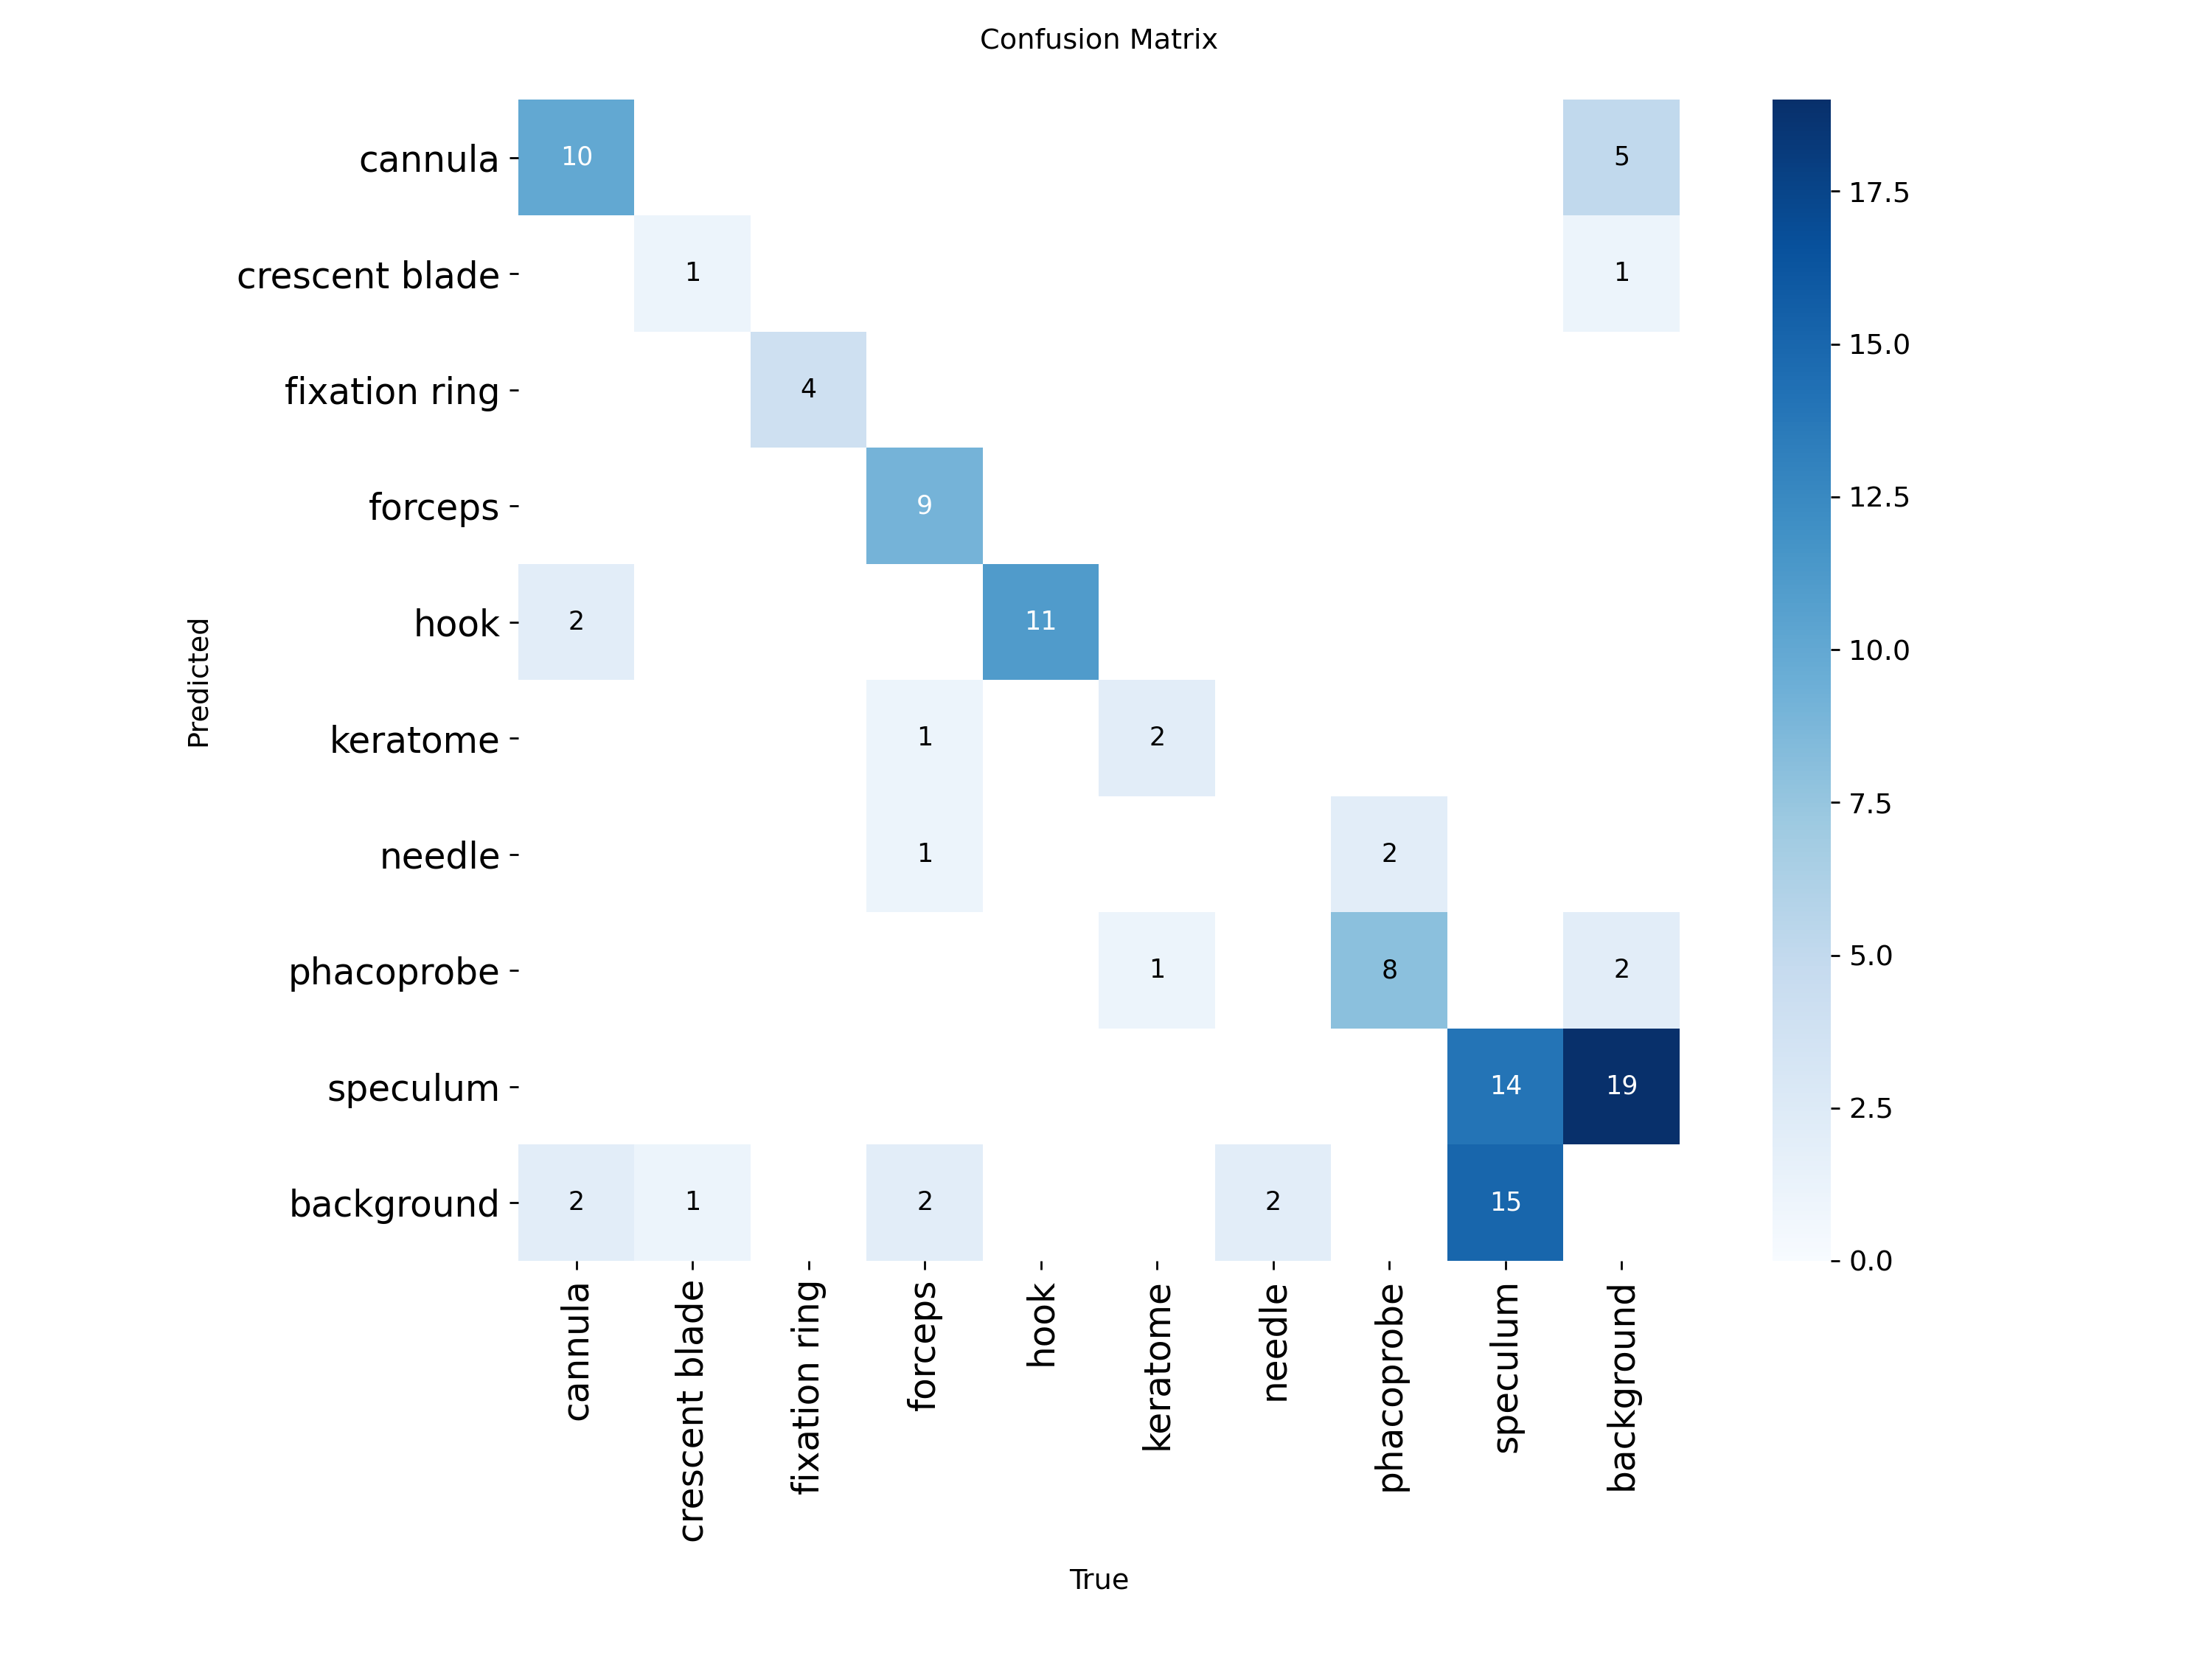

In [48]:
Image(filename=f"{HOME}/runs/detect/train/confusion_matrix.png", width=PLOT_WIDTH)

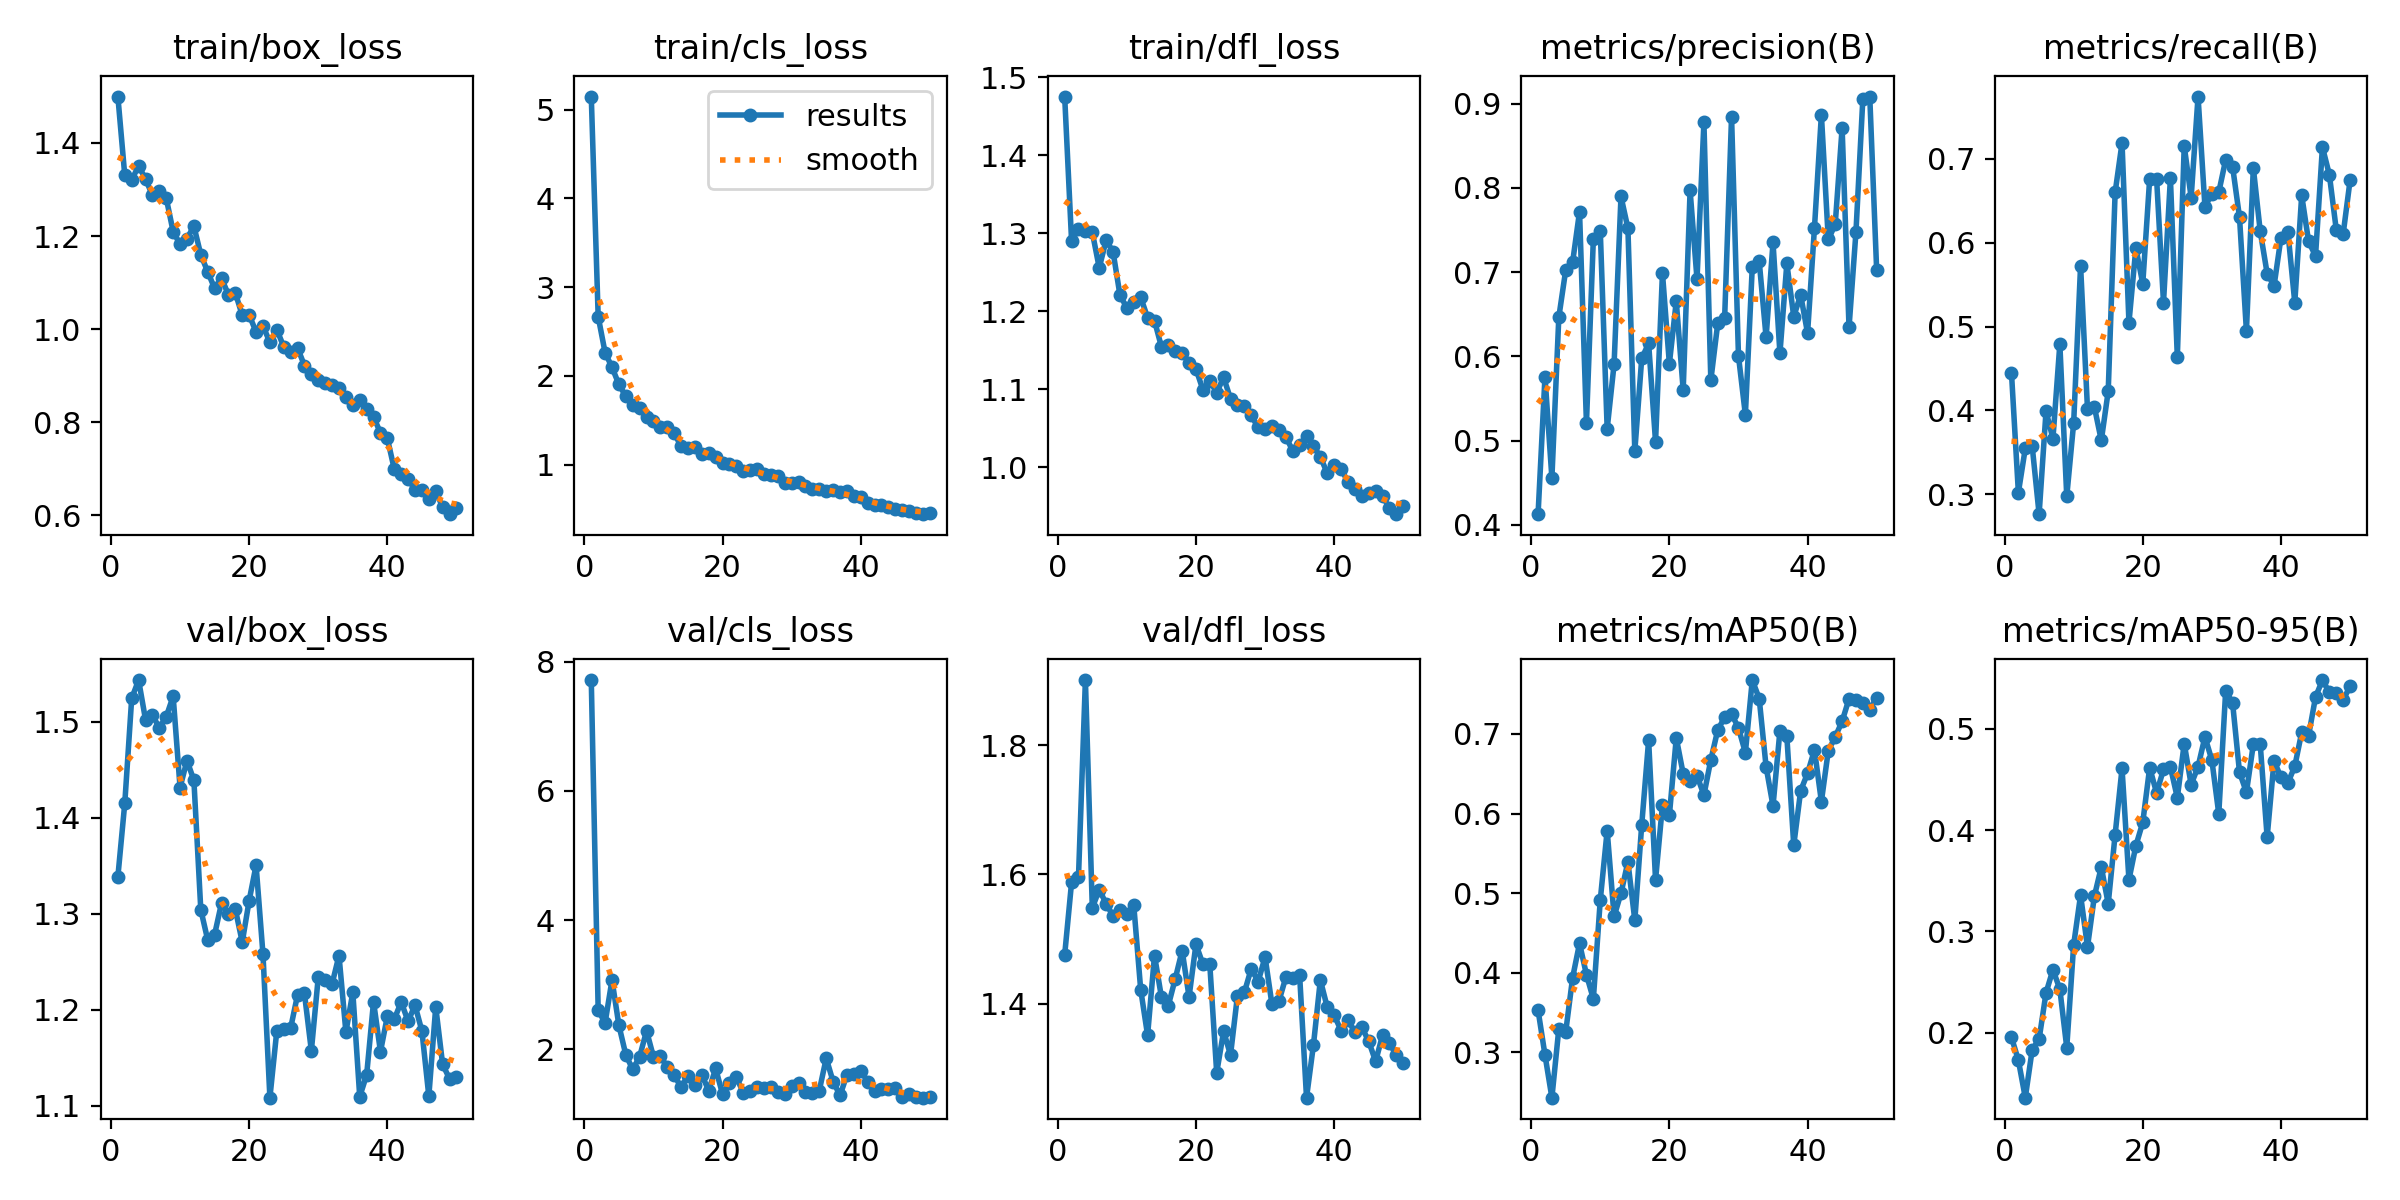

In [49]:
Image(filename=f"{HOME}/runs/detect/train/results.png", width=PLOT_WIDTH)

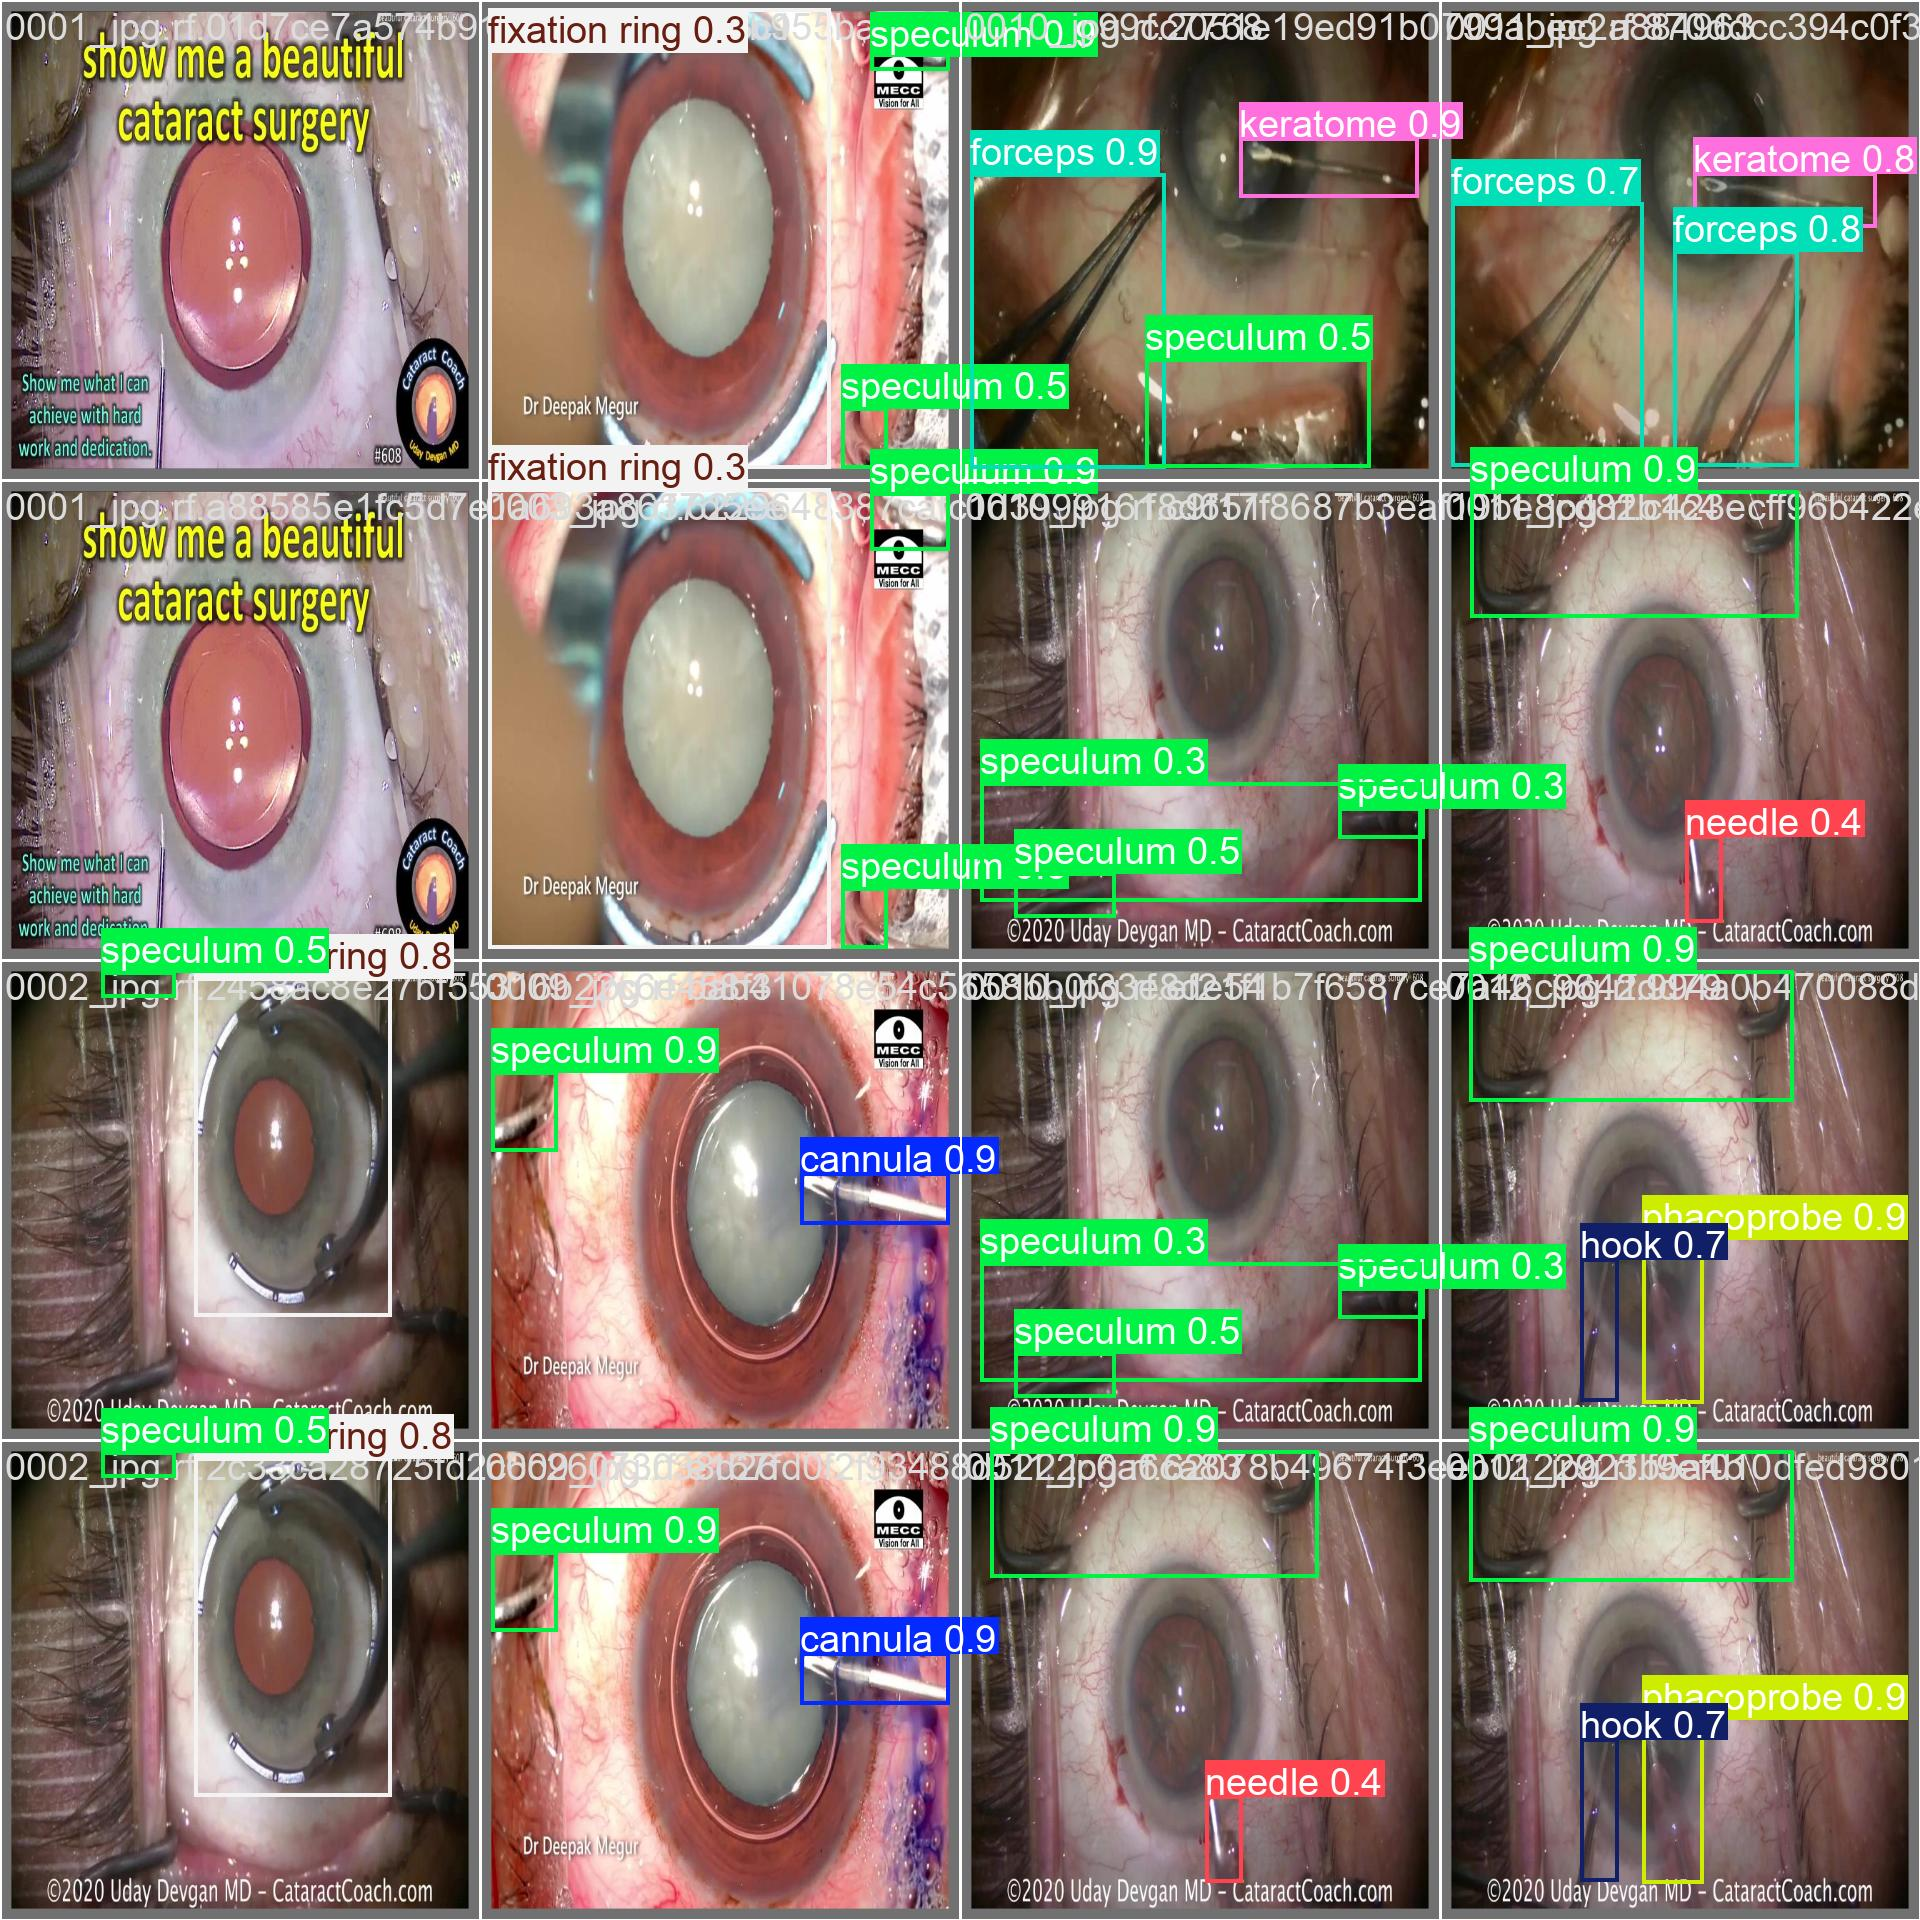

In [50]:
Image(filename=f"{HOME}/runs/detect/train/val_batch0_pred.jpg", width=PLOT_WIDTH, height=PLOT_HEIGHT)

## Validate Custom Model

In [15]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,067 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1662.0±526.4 MB/s, size: 42.1 KB)
val: Scanning /content/CATARACT-3/valid/labels.cache... 42 images, 0 backgrounds, 0 corrupt: 100% 42/42 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:02<00:00,  1.45it/s]
                   all         42         88      0.635      0.714      0.744      0.551
               cannula         12         14      0.675      0.857      0.865      0.601
        crescent blade          2          2      0.628      0.885      0.828      0.608
         fixation ring          4          4      0.949          1      0.995      0.747
               forceps         10         13      0.912      0.692      0.773      0.692
                  hook         11         11      0.813      

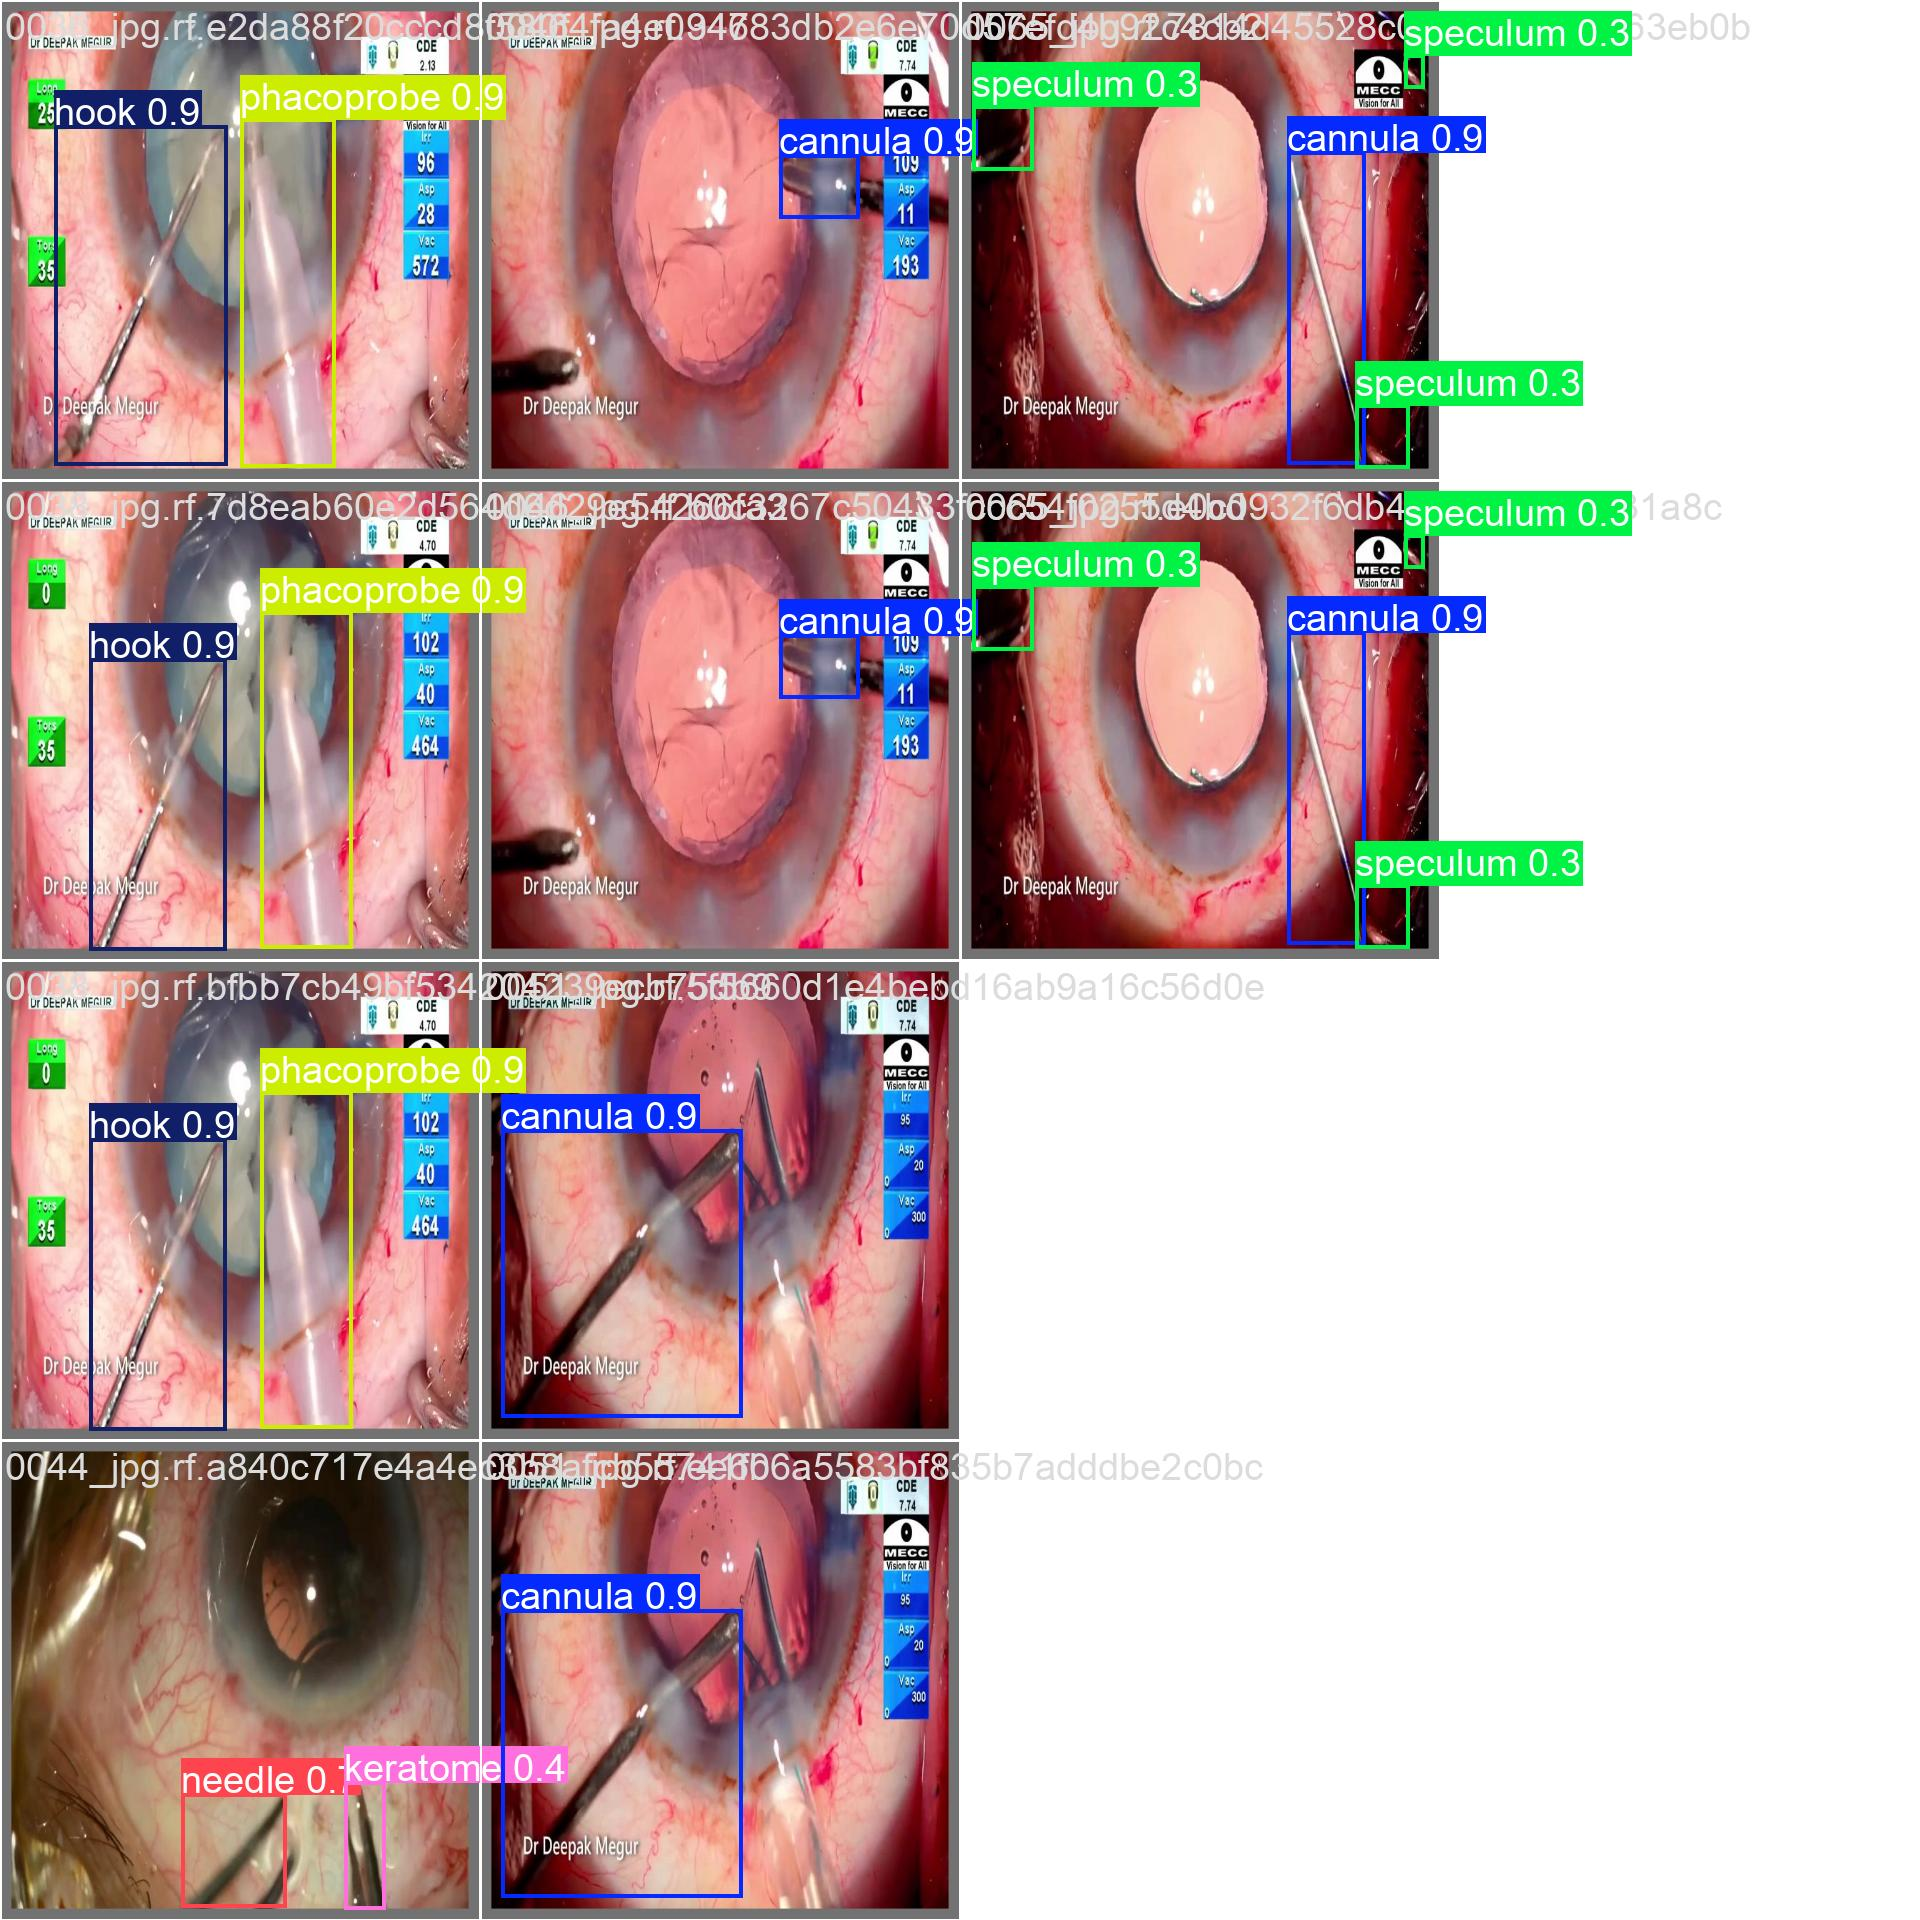

In [51]:
Image(filename=f"{HOME}/runs/detect/val/val_batch2_pred.jpg", width=PLOT_WIDTH, height=PLOT_HEIGHT)

## Inference with Custom Model

In [18]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.2 source={dataset.location}/test/images save=True

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,067 parameters, 0 gradients, 28.5 GFLOPs

image 1/21 /content/CATARACT-3/test/images/0002_jpg.rf.41354c145c627feb990967c90a59f849.jpg: 640x640 4 speculums, 16.3ms
image 2/21 /content/CATARACT-3/test/images/0002_jpg.rf.74ce4e4bde3a5f91d52ed818670b17c1.jpg: 640x640 4 speculums, 16.3ms
image 3/21 /content/CATARACT-3/test/images/0008_jpg.rf.17314865ad0d2b7d576a7d6fb75208ee.jpg: 640x640 1 forceps, 1 keratome, 16.2ms
image 4/21 /content/CATARACT-3/test/images/0014_jpg.rf.080a896fc808dee15d8786ca24098502.jpg: 640x640 2 hooks, 1 needle, 2 speculums, 16.2ms
image 5/21 /content/CATARACT-3/test/images/0014_jpg.rf.c9d6c9dcf63444705c2feeac5bd42370.jpg: 640x640 2 hooks, 1 needle, 2 speculums, 16.3ms
image 6/21 /content/CATARACT-3/test/images/0015_jpg.rf.f6bf0735ae36a24d02ff0813cf457eda.jpg: 640x640 2 forcepss, 16.2ms
image 7/21 /content/CATARACT-3/test/images/0024_jpg.rf.8d6fbe

### Let's take a look at few results.

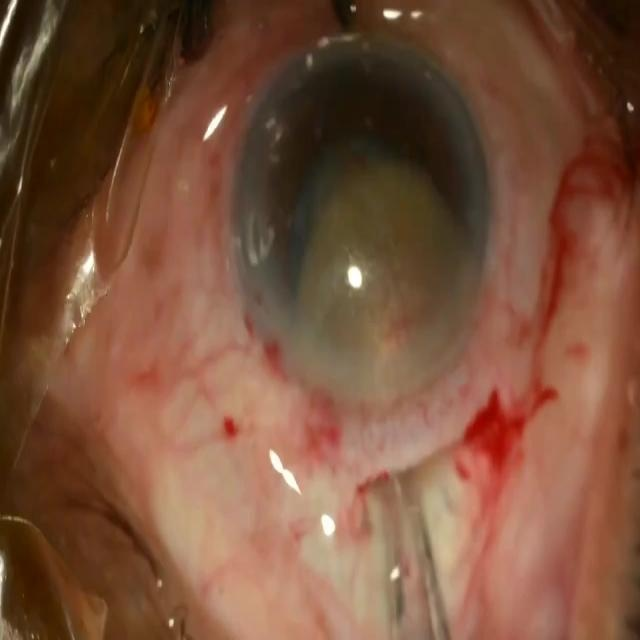

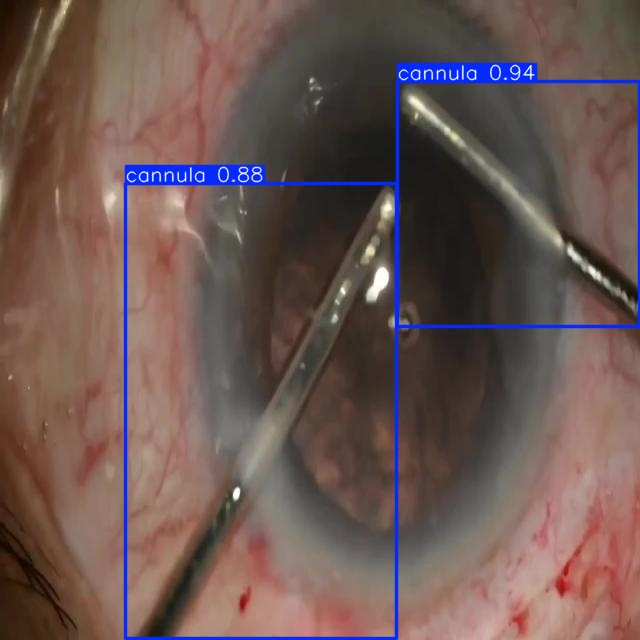

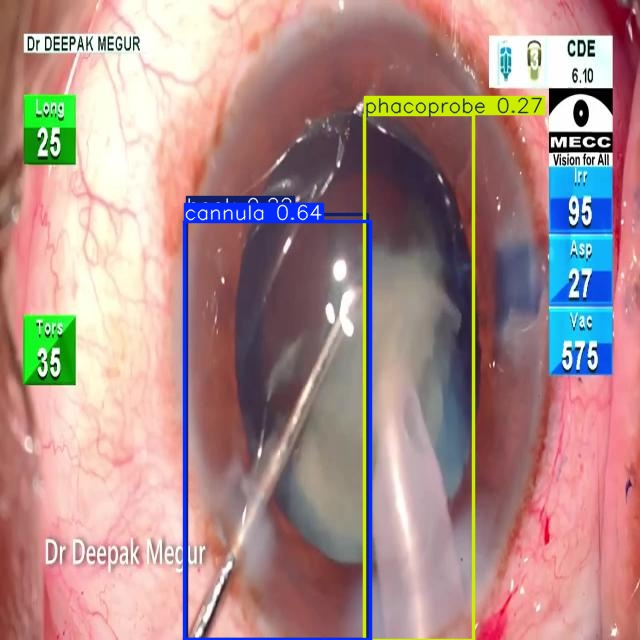

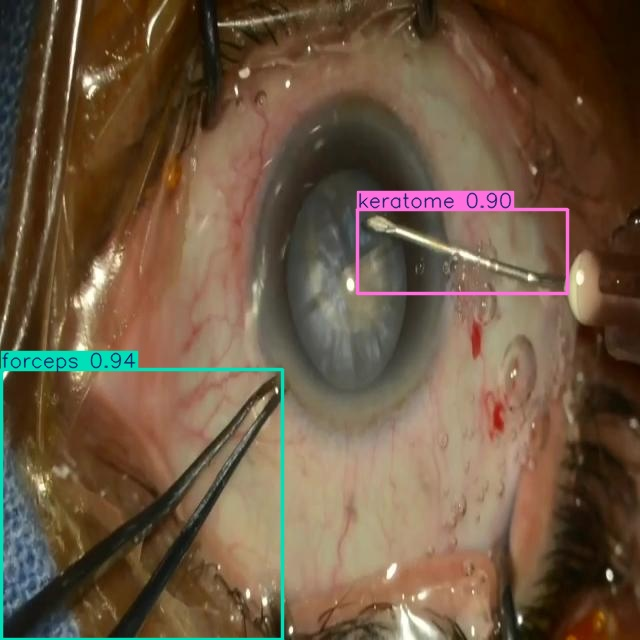

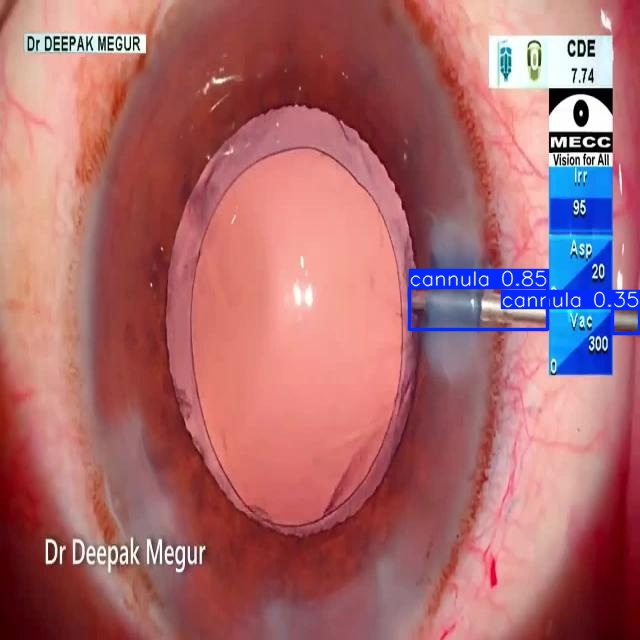

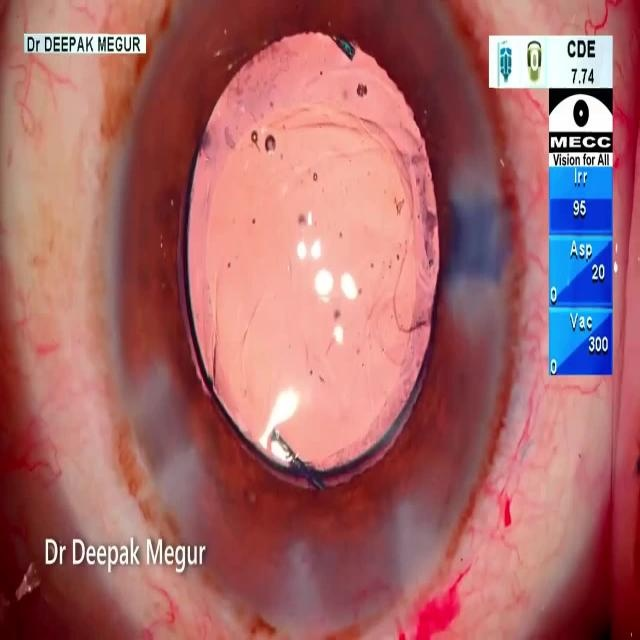

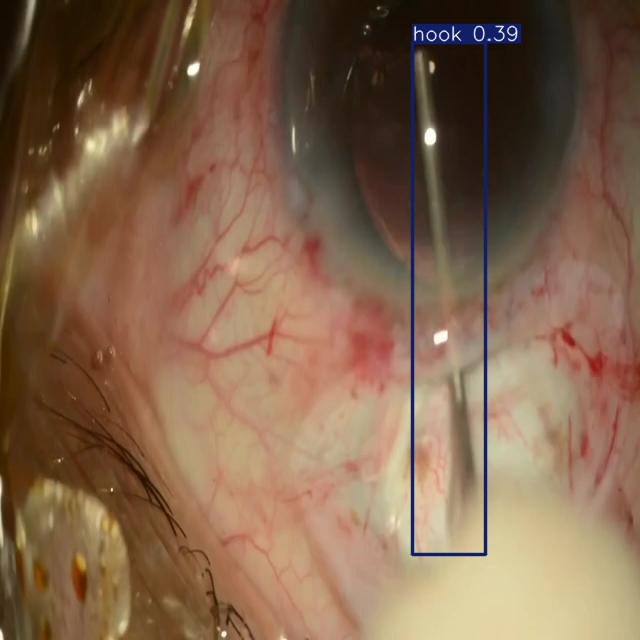

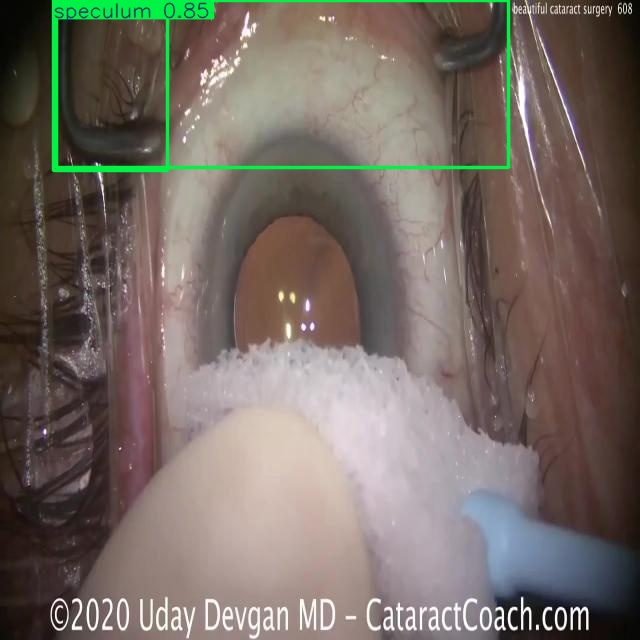

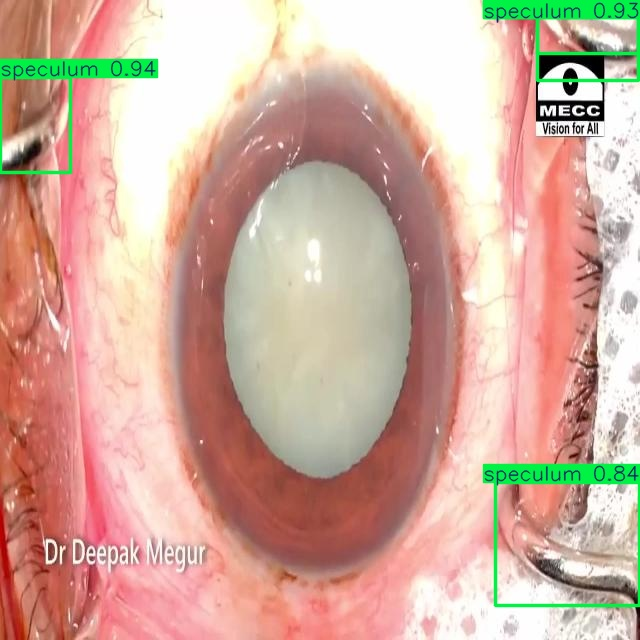

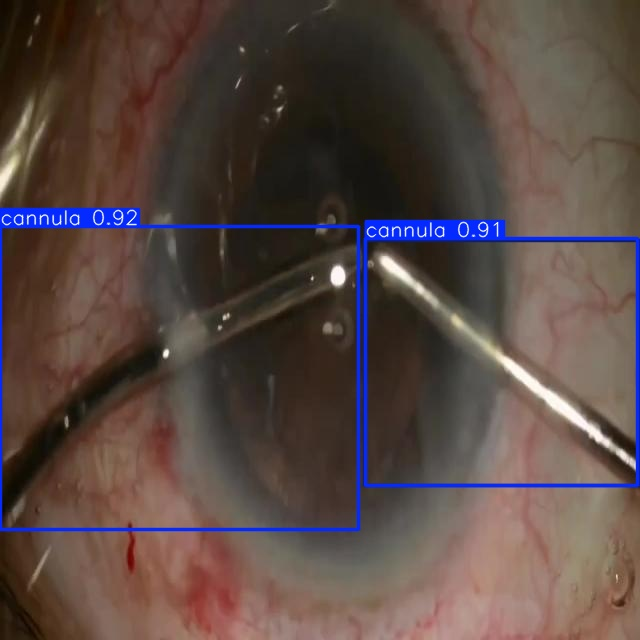

In [53]:
base_path = '/content/runs/detect/'

subfolders = [os.path.join(base_path, d) for d in os.listdir(base_path)
              if os.path.isdir(os.path.join(base_path, d)) and d.startswith('predict')]

latest_folder = max(subfolders, key=os.path.getmtime)

image_paths = glob.glob(f'{latest_folder}/*.jpg')[:10]

for image_path in image_paths:
    display(Image(filename=image_path, width=IMAGE_SIZE))
    print("\n")

In [36]:
model_size = os.path.getsize(f"{HOME}/runs/detect/train/weights/best.pt") / 1e6
model_size

22.523555

In [24]:
max_map50 = 0.0
max_map50_95 = 0.0
ind1 = 0
ind2 = 0
with open(f"{HOME}/runs/detect/train/results.csv", "r") as f:
    lines = f.readlines()
    for line in lines[-1:]:
        metrics = line.split(",")
        map50 = float(metrics[7])
        if map50 > max_map50:
          max_map50 = map50
          ind1 = metrics[0]
        map50_95 = float(metrics[8])
        if map50_95 > max_map50_95:
          max_map50_95 = map50_95
          ind2 = metrics[0]

In [34]:
print(f"max_map | max_map50_90\n{ max_map50:.3f}   |   {max_map50_95:.3f}")

max_map | max_map50_90
0.746   |   0.542
